# Hybrid PSO-GA

In [52]:
from random import sample, choice, shuffle, gauss
import matplotlib.pyplot as plt
from math import cos, pi
import copy
import numpy as np
from numpy.random import uniform

### Define Rastrigin Benchmark

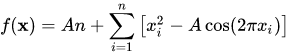

where A=10 and x_{i} in [-5.12,5.12]. It has a global minimum at {x} = {0}  where f({x})=0

In [53]:
def f(x):
    return 10*len(x) + sum(map(lambda t: t**2 - 10*cos(2*pi*t),x))

In [54]:
f([1,2,3,-1,-2])

19.0

In [55]:
f([1,-3])

10.0

In [56]:
f([0,0,0,0,0,0,0,0,0,0])

0.0

In [57]:
f(np.random.uniform(-5.12,5.12,10))

154.97236112793792

### Problem definition

In [58]:
costfunction = f

dimension = 10     # number of var.

varMin = -5.12
varMax = 5.12
domain = varMax - varMin

vel_max = domain / 10
vel_min = -vel_max

dic = {'minimize':0, 'maximize':1}
optimization = dic['minimize']

### PSO & GA Parameters

In [59]:
n_iterations = 1000
n_particles = 100

w = 0.729844       # inertia weight
c1 = 1.496180      # personal learning coefficient
c2 = 1.496180      # global learning coefficient

# GA Parameters
nCrossover = 70
nMutation = 20

# crossover hyperparameter
alpha = 0.5

### GA operators

In [65]:
class Particle:
    # initilizer
    def __init__(self, genome=None, velocity=None, personal_best = None):
        if type(genome) == type(np.array([1,2])):
            self.position = genome
        else:
            self.position = uniform(varMin,varMax,dimension)
        
        if type(velocity) == type(np.array([1,2])):
            self.velocity = velocity
        else:
            self.velocity = uniform(vel_min,vel_max,dimension)
        
        if type(personal_best) == type(np.array([1,2])):
            if self.cost>costfunction(personal_best):
                self.p_best_position = personal_best
                self.p_best_cost = costfunction(personal_best)
            else:
                self.p_best_position = copy.deepcopy(self.position)
                self.p_best_cost = self.cost
        else:
            self.p_best_position = copy.deepcopy(self.position)
            self.p_best_cost = self.cost
    
    @property
    def cost(self):
        return costfunction(self.position)

    def update(self):
        r1 = uniform(0,1,dimension)
        r2 = uniform(0,1,dimension)
        
        # personal and global learning coefficients
        p_co = c1 * r1
        g_co = c2 * r2
        
        # update the new velocity
        self.velocity = w * self.velocity \
                        + p_co * (self.p_best_position - self.position) \
                        + g_co * (g_best_position - self.position)
        
        # check the velocity components bounds
        for i in range(dimension):
            if self.velocity[i] > vel_max:
                self.velocity[i] = vel_max
            if self.velocity[i] < vel_min:
                self.velocity[i] = vel_min
        
        # update position
        self.position += self.velocity
        
        # velocity mirroring
        for i in range(dimension):
            if self.position[i] > varMax:
                self.position[i] = varMax
                self.velocity[i] *= -1
            if self.position[i] < varMin:
                self.position[i] = varMin
                self.velocity[i] *= -1
        
        # check for personal best record
        if self.cost < self.p_best_cost:
            self.p_best_position = copy.deepcopy(self.position)
            self.p_best_cost = self.cost
    
    def crossover(self,other):
        gamma = uniform(-alpha,1+alpha, dimension)
        
        offspring1 = gamma*self.position + (1-gamma)*other.position
        offspring2 = gamma*other.position + (1-gamma)*self.position
        
        offspring1[offspring1>varMax] = varMax
        offspring1[offspring1<varMin] = varMin
        offspring2[offspring2>varMax] = varMax
        offspring2[offspring2<varMin] = varMin
        
        velocity1 = gamma*self.velocity + (1-gamma)*other.velocity
        velocity2 = gamma*other.velocity + (1-gamma)*self.velocity
        
        velocity1[velocity1>vel_max] = vel_max
        velocity1[velocity1<vel_min] = vel_min
        velocity2[velocity2>vel_max] = vel_max
        velocity2[velocity2<vel_min] = vel_min
        
        b_position = self.p_best_position if self.p_best_cost<other.p_best_cost else other.p_best_position
        
        child1 = Particle(offspring1,velocity1,b_position)
        child2 = Particle(offspring2,velocity2,b_position)
        
        return [child1, child2]
    
    def mutate(self):
        temp_genome = self.position[:]
        i = choice(range(dimension))
        sigma = (varMax - varMin) / 10
        temp_genome[i] = min(max(temp_genome[i] + gauss(0, sigma), varMin), varMax)
        return Particle(temp_genome, self.velocity, self.p_best_position)

#### Define the swarm population

In [66]:
def sort_population(x):
    return sorted(x, key=lambda t: t.cost, reverse=optimization)

In [67]:
particles = [Particle() for _ in range(n_particles)]

def global_best():
    g_best = copy.deepcopy(sorted(particles,
              key = lambda t:t.p_best_cost, reverse=optimization)[0])
    global g_best_cost, g_best_position
    g_best_cost = g_best.p_best_cost
    g_best_position = g_best.position

global_best()

In [68]:
# an empty list to record the best solution
best_positions = [g_best_position]
best_costs = [g_best_cost]

#### Define the main loop

In [69]:
for it in range(n_iterations):
    # PSO part
    for i in particles:
        i.update()
    
    # --------------------------------
    # Genetic Part
    # random selection & crossover
    popc = []
    candidates = sample(particles, nCrossover)
    shuffle(candidates)
    
    for i in range(0,nCrossover,2):
        parent1 = candidates[i]
        parent2 = candidates[i+1]
        
        popc += parent1.crossover(parent2)
    
    
    # random selection & mutation
    popm = []
    candidates = sample(particles, nMutation)
    for i in candidates:
        popm.append(i.mutate())
    
    # merge & sort & truncate
    pop_overall = particles + popc + popm
    pop_overall = sort_population(pop_overall)
    particles = pop_overall[:n_particles]
    
    
    # ---------------------------------
    global_best()
    
    best_positions.append(g_best_position)
    best_costs.append(g_best_cost)
    
    # print information
    print (f"loop : {it} \nglobal_best_cost: {best_costs[-1]} \nglobal_best_position: {best_positions[-1]} \n{'-'*30}")

loop : 0 
global_best_cost: 83.87562675182593 
global_best_position: [ 0.17048434 -1.09912067 -2.84896372  0.18776299  2.98796062 -1.85841501
 -0.91723591 -1.77212937 -3.89887749  0.76157846] 
------------------------------
loop : 1 
global_best_cost: 72.57056075193444 
global_best_position: [ 0.57378889  2.12347081 -2.08485229  2.22294493  0.09139467  1.01734777
 -1.20688599 -1.06556644 -1.81895433 -1.94509574] 
------------------------------
loop : 2 
global_best_cost: 56.13725344891142 
global_best_position: [ 1.06639418  0.65347594  0.13919649 -0.92912497  1.2342139   0.09518106
 -0.93952684 -1.18657397  0.24723162 -0.9567363 ] 
------------------------------
loop : 3 
global_best_cost: 39.4653340843267 
global_best_position: [ 0.9796344   0.08274776 -0.8377753   0.97074896  1.06661565 -0.12267209
 -0.93371208 -1.95338024 -2.63847615 -1.97972085] 
------------------------------
loop : 4 
global_best_cost: 39.4653340843267 
global_best_position: [ 0.58795036  0.0252993  -0.34214866 

loop : 46 
global_best_cost: 24.29536425150245 
global_best_position: [-0.94000908 -1.01761128  0.84068526  1.0574108   1.09292848  0.23325657
  0.06255154 -0.80202797 -1.99765082 -1.9695462 ] 
------------------------------
loop : 47 
global_best_cost: 24.29536425150245 
global_best_position: [-0.83797373 -0.98547452  1.0149326   1.07032419  1.01767286  0.18058927
  0.06747919 -0.1074932  -2.0401649  -2.0926723 ] 
------------------------------
loop : 48 
global_best_cost: 24.29536425150245 
global_best_position: [-0.96210127 -0.99393719  0.91993082  1.07195768  0.85972064  0.06211476
 -0.01489212 -0.16560072 -1.9179979  -2.01554799] 
------------------------------
loop : 49 
global_best_cost: 24.29536425150245 
global_best_position: [-0.82283813 -0.85530717  1.13707595  1.12622272  1.08549753  0.09652954
 -0.05491109  0.06510319 -1.95938212 -2.01085767] 
------------------------------
loop : 50 
global_best_cost: 24.29536425150245 
global_best_position: [-0.07586617 -0.93911867  0.81

loop : 94 
global_best_cost: 11.27606755615686 
global_best_position: [ 0.01983307 -1.04810115  0.9687446   1.00129463  1.03983007 -0.01604343
 -0.01120438 -0.96039096 -1.93803642 -0.05280524] 
------------------------------
loop : 95 
global_best_cost: 11.27606755615686 
global_best_position: [-0.00333492 -1.1065421   0.97569964  0.9595749   1.05797337 -0.00510202
 -0.00826631 -1.11952587 -1.95883356 -0.00645769] 
------------------------------
loop : 96 
global_best_cost: 11.27606755615686 
global_best_position: [ 0.01385913 -0.90248863  0.97057625  0.96547908  1.01513784 -0.06640187
 -0.02267099 -1.00393196 -1.97789664 -0.09356473] 
------------------------------
loop : 97 
global_best_cost: 11.27606755615686 
global_best_position: [ 0.03876089 -0.92955414  0.92709329  0.99056552  1.03241053 -0.09636372
  0.04375761 -1.03641573 -1.99827757  0.08314229] 
------------------------------
loop : 98 
global_best_cost: 11.27606755615686 
global_best_position: [ 0.01782654 -0.98608575  0.94

loop : 144 
global_best_cost: 8.765625159119125 
global_best_position: [ 0.08879403 -0.97778505  0.98048921  0.01291383  0.99423357  0.02487976
  0.01098871 -1.03890818 -1.99393984 -0.06345345] 
------------------------------
loop : 145 
global_best_cost: 8.765625159119125 
global_best_position: [ 0.03468279 -1.02613187  1.06376249 -0.02802588  1.02136162 -0.01095176
  0.01302903 -1.02190195 -1.9662461  -0.05594482] 
------------------------------
loop : 146 
global_best_cost: 8.765625159119125 
global_best_position: [ 0.07809709 -1.00202274  1.06101369  0.01061911  1.02077886 -0.03435799
  0.01726771 -1.03692055 -1.95318083  0.0497601 ] 
------------------------------
loop : 147 
global_best_cost: 8.765625159119125 
global_best_position: [-0.03743558 -1.00480607  1.01465224 -0.04304228  0.93502565 -0.02649636
 -0.02161349 -0.99131223 -1.98471456  0.03081731] 
------------------------------
loop : 148 
global_best_cost: 8.765625159119125 
global_best_position: [-2.38672973e-02 -9.57622

loop : 191 
global_best_cost: 5.629509289965483 
global_best_position: [ 0.03686336 -0.99928721  0.99380457 -0.02599029  1.03171089 -0.03394828
  0.0563324  -0.0205315   0.10633742  0.06220834] 
------------------------------
loop : 192 
global_best_cost: 5.629509289965483 
global_best_position: [-0.02585059 -1.04279828  0.93611515  0.0017326   1.01727343 -0.00644217
  0.00439449 -0.0411083   0.03621965  0.07049728] 
------------------------------
loop : 193 
global_best_cost: 4.8666806385214585 
global_best_position: [ 0.00214212 -1.00638153  1.01816376 -0.01240578  0.97236113 -0.0294638
  0.02918418  0.02691909 -0.07605557 -0.25079106] 
------------------------------
loop : 194 
global_best_cost: 4.8666806385214585 
global_best_position: [-0.01415572 -1.04433491  1.01100297 -0.00457519  0.04344179  0.01131426
  0.00708914  0.03858414  0.10405668 -0.09392475] 
------------------------------
loop : 195 
global_best_cost: 3.175149481068388 
global_best_position: [ 0.00138489 -1.00512968

loop : 239 
global_best_cost: 0.6293734014440133 
global_best_position: [-0.01699555 -0.0052461  -0.02121234 -0.0107454   0.02566867  0.00328072
 -0.00962114  0.0216147  -0.01372394 -0.02964128] 
------------------------------
loop : 240 
global_best_cost: 0.6293734014440133 
global_best_position: [-0.03138576 -0.01544966  0.08080938 -0.02297682  0.0377275   0.02904623
 -0.01270597  0.01249896 -0.03278787 -0.03512735] 
------------------------------
loop : 241 
global_best_cost: 0.6293734014440133 
global_best_position: [-0.03037045  0.00609871 -0.08556027 -0.03093242  0.03181195  0.05744534
 -0.0130883   0.01656995 -0.02119671 -0.04920584] 
------------------------------
loop : 242 
global_best_cost: 0.6293734014440133 
global_best_position: [-0.01602147  0.01620871 -0.13025959 -0.01316586  0.02369643  0.02514429
 -0.01123882  0.02344148 -0.00272289 -0.04795271] 
------------------------------
loop : 243 
global_best_cost: 0.6293734014440133 
global_best_position: [ 0.02140991  0.0337

loop : 291 
global_best_cost: 0.16766660046926063 
global_best_position: [-0.00127772  0.0106264  -0.00528796  0.00947437  0.02573079 -0.00819032
 -0.01019478  0.01293594  0.01613065  0.00680547] 
------------------------------
loop : 292 
global_best_cost: 0.1489749373767495 
global_best_position: [ 0.01309263 -0.00367602 -0.00480166  0.00037181  0.01085105  0.00804126
  0.00187666 -0.00604663  0.00411771 -0.01743003] 
------------------------------
loop : 293 
global_best_cost: 0.12999402559935902 
global_best_position: [ 0.00478748 -0.01184605 -0.00637404 -0.0009068   0.01001129  0.0094922
  0.00650062 -0.00287506  0.01385261  0.00424858] 
------------------------------
loop : 294 
global_best_cost: 0.12633158663459199 
global_best_position: [-0.00238079  0.0079144  -0.01418826 -0.0143319   0.00220418  0.01411419
  0.00944488 -0.01470539 -0.00128092 -0.00366718] 
------------------------------
loop : 295 
global_best_cost: 0.12633158663459199 
global_best_position: [ 0.00199074 -0.0

loop : 338 
global_best_cost: 0.0011815181499486016 
global_best_position: [-0.00035742  0.00097685  0.00151814 -0.00038773  0.00052949 -0.00084698
  0.00015006  0.00087845  0.00106707  0.00145904] 
------------------------------
loop : 339 
global_best_cost: 0.0011815181499486016 
global_best_position: [-0.00133577  0.0004696   0.00168487 -0.00070919 -0.00048937 -0.00068584
  0.00051884 -0.00026012  0.00167212 -0.00043503] 
------------------------------
loop : 340 
global_best_cost: 0.0010047101157937277 
global_best_position: [-9.28943827e-04  4.29936793e-04  6.36826534e-04 -3.46491500e-05
 -2.42825785e-04 -1.02942915e-03  4.91226374e-04 -6.10469063e-04
  1.18549923e-03  6.86786570e-04] 
------------------------------
loop : 341 
global_best_cost: 0.0010047101157937277 
global_best_position: [-9.80841135e-04 -2.88090542e-04  6.89722490e-04 -5.65819965e-05
 -9.88793695e-04 -1.20797076e-03  8.26479785e-04 -1.15051471e-03
  1.86554351e-03  4.02743727e-04] 
-----------------------------

loop : 384 
global_best_cost: 2.855219469211079e-05 
global_best_position: [ 3.16578508e-05 -3.65608244e-05 -1.96461196e-04 -2.05307500e-04
  9.32637308e-05 -3.77876236e-04  2.50622642e-04  8.32175878e-05
 -4.88740207e-05  4.88072692e-05] 
------------------------------
loop : 385 
global_best_cost: 2.855219469211079e-05 
global_best_position: [ 7.16436863e-05 -2.27963129e-04 -1.93053701e-04  1.23917241e-04
 -1.39852985e-04 -7.23461838e-05  6.87990312e-05  1.50422392e-04
 -8.76124989e-06 -1.10816603e-04] 
------------------------------
loop : 386 
global_best_cost: 2.855219469211079e-05 
global_best_position: [ 2.10816868e-04 -1.73695237e-04 -1.99583738e-04 -1.32754594e-04
  1.06450885e-04 -4.44632196e-04  6.22658571e-05 -4.73538815e-05
  7.10757527e-05  7.02921181e-06] 
------------------------------
loop : 387 
global_best_cost: 2.855219469211079e-05 
global_best_position: [ 1.10080141e-04 -2.08437747e-04 -5.90982520e-05 -5.20902279e-05
 -3.76711385e-05  4.41360533e-05 -2.17491144e-0

------------------------------
loop : 424 
global_best_cost: 7.896136651197594e-07 
global_best_position: [-4.12008485e-05 -2.03394472e-06  1.92231220e-05  3.67320175e-05
  9.21392579e-06  3.80230041e-05 -4.88226977e-05  8.66560677e-06
 -7.85656123e-06 -4.07064239e-05] 
------------------------------
loop : 425 
global_best_cost: 7.896136651197594e-07 
global_best_position: [-7.66796815e-05 -7.37796244e-05  7.15846888e-06 -1.56272190e-07
 -3.58930934e-05  2.89966579e-05 -4.36843434e-05  3.70780827e-05
  1.39912549e-05  1.93102222e-07] 
------------------------------
loop : 426 
global_best_cost: 7.896136651197594e-07 
global_best_position: [-2.32792148e-05 -1.83790096e-05  1.59020744e-05  5.85228082e-06
 -6.69429593e-05  5.38132082e-05  1.79751977e-05  2.25983745e-05
  3.45312125e-05 -1.92545220e-05] 
------------------------------
loop : 427 
global_best_cost: 7.896136651197594e-07 
global_best_position: [ 3.53121039e-05 -2.87415850e-05  6.80418130e-06 -4.24322311e-05
 -4.53220045e-05

loop : 471 
global_best_cost: 2.234864382444357e-08 
global_best_position: [-3.48220271e-06  7.13037931e-06  2.16984175e-06  1.23956875e-05
  1.19263881e-06  5.15998961e-06  8.72326961e-06 -3.19082620e-06
 -4.97988361e-06  4.66184998e-06] 
------------------------------
loop : 472 
global_best_cost: 2.234864382444357e-08 
global_best_position: [-5.40020048e-06  4.97060419e-06  7.42608785e-06  9.90299285e-06
  2.82363913e-07 -3.40035576e-06  5.10607425e-06 -3.74817601e-06
 -5.61373648e-07  2.38223756e-06] 
------------------------------
loop : 473 
global_best_cost: 2.234864382444357e-08 
global_best_position: [ 1.79287253e-06  4.16033065e-06  7.45023533e-06  6.37196919e-06
 -1.09261245e-05 -2.15438503e-06 -1.39494758e-06 -1.02857137e-05
 -6.88527453e-06  8.79886339e-06] 
------------------------------
loop : 474 
global_best_cost: 2.234864382444357e-08 
global_best_position: [ 5.24755073e-06  2.36819614e-06  8.47853514e-06  3.04527027e-06
 -2.72987527e-06 -7.12531513e-06  8.97187226e-0

loop : 516 
global_best_cost: 6.26741325504554e-10 
global_best_position: [-1.72819029e-06  6.49741305e-07 -8.31265907e-08 -1.81610425e-07
 -1.25872002e-06 -1.72389110e-06 -1.09517546e-06 -1.03354605e-07
  6.09417599e-07 -4.80071892e-07] 
------------------------------
loop : 517 
global_best_cost: 4.3587533582467586e-10 
global_best_position: [-8.37723552e-07 -6.59397744e-07  2.16939224e-07  5.58719057e-08
  9.54800647e-07 -1.74445354e-07  2.00002174e-08 -9.63966340e-08
  1.96202429e-07 -1.41060342e-07] 
------------------------------
loop : 518 
global_best_cost: 3.738875875569647e-10 
global_best_position: [ 2.74502026e-07 -1.60726585e-07 -5.23180748e-07 -4.86126889e-07
  7.91383772e-08 -4.35270258e-07  3.71889470e-07  3.53122261e-07
  3.87646510e-07  8.15093963e-07] 
------------------------------
loop : 519 
global_best_cost: 3.738875875569647e-10 
global_best_position: [ 5.21751524e-07 -9.40836652e-08 -9.32741140e-07 -2.12538291e-07
  5.01709301e-07 -1.11539703e-07  5.48549874e-0

loop : 557 
global_best_cost: 1.0231815394945443e-11 
global_best_position: [-5.39040803e-08 -9.54412958e-08  2.16953648e-08 -1.75817071e-07
 -6.28103499e-08 -3.52852773e-08  1.53863131e-07  1.15658589e-07
  3.50256682e-09 -1.13024593e-08] 
------------------------------
loop : 558 
global_best_cost: 1.0231815394945443e-11 
global_best_position: [ 1.32476114e-07 -3.12155259e-08 -3.74085470e-10 -3.09216854e-09
 -2.07223935e-07 -2.69935488e-08  9.60115763e-08  1.70791186e-07
 -9.81577244e-08  1.30078440e-07] 
------------------------------
loop : 559 
global_best_cost: 1.0231815394945443e-11 
global_best_position: [-3.18695303e-08  5.03298809e-08  3.74391950e-08  3.53186002e-08
 -2.68535452e-07  1.24397813e-08 -1.43062082e-07 -7.48276713e-08
 -4.55566326e-08 -3.26027931e-08] 
------------------------------
loop : 560 
global_best_cost: 1.0231815394945443e-11 
global_best_position: [ 1.13715074e-07  1.14411906e-07 -1.43676730e-07  1.05609802e-08
 -1.57495776e-07 -5.52184094e-10 -5.9024765

------------------------------
loop : 596 
global_best_cost: 3.979039320256561e-13 
global_best_position: [-8.09723822e-09 -2.69112901e-08 -8.37500931e-09  6.15956540e-09
  5.44604863e-09  1.31921438e-08 -9.99579107e-09 -1.85298507e-08
  2.08366604e-08 -2.62366866e-09] 
------------------------------
loop : 597 
global_best_cost: 2.8421709430404007e-13 
global_best_position: [-1.80529178e-08 -6.58731957e-10 -2.26159928e-09 -1.81143669e-08
 -1.89252550e-09 -6.31660848e-09 -5.58194629e-09 -6.23533639e-09
  1.81463146e-08 -1.91195818e-08] 
------------------------------
loop : 598 
global_best_cost: 2.8421709430404007e-13 
global_best_position: [-1.19889799e-08  3.08157504e-09 -3.62348967e-08 -2.23707313e-08
  2.24528607e-08 -4.04959697e-09 -5.93382927e-09  3.40362777e-09
  3.59438584e-08 -4.65554546e-08] 
------------------------------
loop : 599 
global_best_cost: 2.8421709430404007e-13 
global_best_position: [-9.71026522e-09  2.43996952e-09 -1.76096342e-08 -2.05482540e-08
  3.42394691e

loop : 633 
global_best_cost: 1.4210854715202004e-14 
global_best_position: [-2.49791641e-09  9.29335458e-09  8.13607772e-10  7.72335588e-09
 -1.32668366e-09 -1.38316587e-09 -5.09050802e-09 -2.25677375e-09
  2.91811382e-09  9.86012108e-10] 
------------------------------
loop : 634 
global_best_cost: 1.4210854715202004e-14 
global_best_position: [ 2.42613868e-09  2.66457793e-09  7.31644638e-09  1.01430577e-09
 -5.91170421e-09  4.80408335e-09 -1.29515987e-09 -1.15500246e-09
 -9.44239283e-10  4.27635434e-09] 
------------------------------
loop : 635 
global_best_cost: 1.4210854715202004e-14 
global_best_position: [ 7.00947550e-10 -1.64752645e-12  8.93611921e-10 -7.17406752e-09
 -1.91948401e-10  4.98960668e-09  1.47414539e-09  9.23472300e-09
 -1.95286864e-09 -6.04102359e-09] 
------------------------------
loop : 636 
global_best_cost: 1.4210854715202004e-14 
global_best_position: [-2.78934804e-09 -4.24138654e-09  2.79439161e-09 -8.40429027e-09
  1.07945812e-09  2.49241563e-09 -9.6488812

loop : 679 
global_best_cost: 0.0 
global_best_position: [ 1.83052309e-09  1.11333272e-09 -8.11324857e-10  3.23791147e-09
  1.51343334e-09  4.12435014e-11  1.79636165e-09  3.10028149e-09
  7.12072884e-11  9.68636048e-10] 
------------------------------
loop : 680 
global_best_cost: 0.0 
global_best_position: [ 3.64875477e-09  4.29550967e-09  1.14517811e-10  2.76495885e-09
 -8.28631947e-10 -5.40666005e-10  5.00843682e-11 -2.89315867e-09
  2.77126306e-09 -2.68522827e-09] 
------------------------------
loop : 681 
global_best_cost: 0.0 
global_best_position: [ 3.33460579e-09 -1.02503181e-09  1.83881265e-09  3.32621252e-09
 -2.11416025e-09 -2.92260543e-09 -3.77111204e-09  1.22606756e-09
 -1.31663087e-09 -4.49848517e-09] 
------------------------------
loop : 682 
global_best_cost: 0.0 
global_best_position: [ 1.34221431e-09  2.61046244e-09  2.05343492e-09  6.97766343e-10
 -3.18356888e-09 -3.72841373e-09 -6.34684949e-09  7.03830431e-10
 -1.91327444e-09 -3.13877628e-09] 
-------------------

loop : 726 
global_best_cost: 0.0 
global_best_position: [ 6.45246394e-10 -1.64072883e-09 -1.68029612e-09  1.84645315e-09
 -1.74278222e-09  1.32210146e-09  2.61206899e-11 -2.22468852e-09
 -2.51107547e-09  5.34920884e-09] 
------------------------------
loop : 727 
global_best_cost: 0.0 
global_best_position: [ 4.17744315e-09  2.70612984e-09 -1.64503572e-09  8.51505304e-10
 -8.13395866e-10 -1.32360329e-09 -4.22472990e-10 -6.15839183e-09
 -4.32441666e-09  6.16578988e-09] 
------------------------------
loop : 728 
global_best_cost: 0.0 
global_best_position: [ 3.12573374e-09  5.41213018e-09  6.11687846e-10 -2.00682244e-10
  3.47789106e-09 -1.96229267e-09  7.87246289e-10 -2.98918754e-09
  2.96700400e-09  5.35747856e-09] 
------------------------------
loop : 729 
global_best_cost: 0.0 
global_best_position: [ 3.21667822e-10  5.88290480e-09 -1.19389587e-10  1.21076718e-09
  3.65250239e-09 -1.36205524e-09 -8.53168282e-10  6.09428379e-09
  7.96892174e-10  3.14625933e-09] 
-------------------

------------------------------
loop : 774 
global_best_cost: 0.0 
global_best_position: [-1.34189141e-09 -8.13030385e-10  1.47002142e-09 -2.96187690e-09
 -2.08927196e-09  3.25937891e-09 -3.30123786e-09 -6.50792350e-10
 -2.21204798e-09  1.57199058e-09] 
------------------------------
loop : 775 
global_best_cost: 0.0 
global_best_position: [-1.30814001e-09 -2.33813903e-09 -2.91888800e-09 -4.48873210e-09
 -3.04754427e-09  1.65474967e-09 -4.44700012e-09  1.04917465e-09
 -2.58547839e-09  5.41476304e-09] 
------------------------------
loop : 776 
global_best_cost: 0.0 
global_best_position: [-1.34563405e-09  4.83664562e-10 -3.23726599e-09 -1.65499083e-09
 -3.19754888e-09  1.42085051e-09 -5.25186696e-09 -8.24893562e-10
 -1.25183937e-09  6.45426450e-10] 
------------------------------
loop : 777 
global_best_cost: 0.0 
global_best_position: [-9.73657865e-10 -3.43661381e-10 -1.04517558e-10 -2.56002709e-09
 -3.02453044e-09  2.64090802e-09 -4.41749185e-09 -1.95952086e-09
 -5.46442708e-10 -7.561

loop : 820 
global_best_cost: 0.0 
global_best_position: [ 5.51879143e-10  1.58591984e-09 -1.10363126e-09  2.99019948e-09
 -4.60898593e-09  2.15618514e-09 -5.53135405e-09 -4.19604630e-09
  6.47204755e-09 -4.59122946e-10] 
------------------------------
loop : 821 
global_best_cost: 0.0 
global_best_position: [-2.23958964e-10  1.47821069e-09  1.18087698e-09  5.11195458e-09
  1.36945471e-09  9.33271205e-10  1.38100261e-09  3.90261953e-10
  6.37280846e-09 -2.56284939e-09] 
------------------------------
loop : 822 
global_best_cost: 0.0 
global_best_position: [-6.06232798e-10 -1.17281786e-09  4.62219739e-09 -6.77912835e-11
  4.11351995e-09  1.70417847e-09  2.17783400e-09  1.72351505e-09
 -1.98274889e-09  9.73069407e-10] 
------------------------------
loop : 823 
global_best_cost: 0.0 
global_best_position: [-6.32276108e-11 -5.11699908e-10  2.46496287e-09  1.29824144e-10
  2.26292834e-09  2.57421545e-09  4.06828081e-09  5.44631441e-09
  3.07047740e-09  3.03969964e-10] 
-------------------

loop : 853 
global_best_cost: 0.0 
global_best_position: [ 2.29870399e-10  2.83973223e-09 -9.26206287e-10  1.25604256e-09
  3.06008235e-09 -5.68453852e-09 -1.43415908e-09 -3.70303100e-09
  1.13050255e-10 -3.05230735e-09] 
------------------------------
loop : 854 
global_best_cost: 0.0 
global_best_position: [ 2.27691704e-10  5.90407670e-09  2.55178663e-10  1.20469164e-09
  3.17180146e-09  1.71383791e-09  3.77982294e-10 -2.21525657e-09
 -6.34677121e-10  3.27599668e-10] 
------------------------------
loop : 855 
global_best_cost: 0.0 
global_best_position: [-7.28289690e-10  1.60428080e-09  1.23312679e-09  1.73094107e-09
  4.50996881e-09  9.22320681e-10 -6.24468259e-09 -5.34920237e-10
 -9.64993300e-10  2.48564600e-09] 
------------------------------
loop : 856 
global_best_cost: 0.0 
global_best_position: [ 1.93090802e-10 -3.35134587e-10  3.09364565e-09  1.64611873e-09
  2.87998255e-09  1.90685753e-10 -5.63409767e-09 -6.57542856e-10
 -7.23450226e-10 -1.72116089e-09] 
-------------------

------------------------------
loop : 899 
global_best_cost: 0.0 
global_best_position: [ 2.98898299e-09 -1.71698428e-09 -6.95922393e-10 -3.29676385e-10
  3.86144370e-09 -5.37955819e-09 -4.51658397e-10 -5.88897583e-09
  4.59939035e-09 -1.09986695e-09] 
------------------------------
loop : 900 
global_best_cost: 0.0 
global_best_position: [ 2.67872852e-09 -2.21839535e-09 -1.12176204e-09 -7.51575558e-10
  6.23361416e-09 -3.74049830e-09 -8.02020309e-12 -1.50399063e-09
  5.41316536e-09  1.32201695e-09] 
------------------------------
loop : 901 
global_best_cost: 0.0 
global_best_position: [ 2.98254914e-09 -2.37847737e-09 -1.14886763e-09 -1.41025057e-09
  3.35562817e-09 -3.12472457e-09 -1.11611002e-10 -2.59300738e-09
  5.87307249e-09  8.98674831e-10] 
------------------------------
loop : 902 
global_best_cost: 0.0 
global_best_position: [-2.41783984e-09 -3.68891822e-09 -1.24211423e-09  3.85898989e-09
  2.35721888e-09 -2.67392960e-09  8.44005516e-10 -1.68394296e-09
  5.28722614e-09  2.373

loop : 939 
global_best_cost: 0.0 
global_best_position: [-4.94964919e-10  1.07622813e-09 -2.64998811e-09  2.09971841e-09
  3.36174698e-09 -2.94354726e-09 -2.85735956e-09 -4.43862037e-09
  5.10153455e-09  4.51447651e-09] 
------------------------------
loop : 940 
global_best_cost: 0.0 
global_best_position: [-2.30714167e-09  1.36258560e-09  2.36036701e-09  2.01362439e-09
  9.81823508e-10 -2.47865107e-09 -8.93284226e-10 -1.30985995e-09
  4.26252993e-09  3.88230774e-09] 
------------------------------
loop : 941 
global_best_cost: 0.0 
global_best_position: [-2.97261184e-09  2.04173271e-09 -9.26601534e-11  1.80281480e-09
  3.65329724e-10 -1.79963478e-09 -4.42755043e-10  4.50746913e-10
  3.29709478e-09  4.90179828e-09] 
------------------------------
loop : 942 
global_best_cost: 0.0 
global_best_position: [-5.54935016e-09  1.82347465e-09  1.35544497e-09  9.42524842e-10
 -7.02293042e-10 -9.21376233e-10  1.33877234e-09  1.52372280e-09
  1.87332705e-09  5.96734879e-09] 
-------------------

loop : 983 
global_best_cost: 0.0 
global_best_position: [ 2.71609183e-10  4.36023380e-09 -2.63814041e-09 -3.12406706e-09
 -1.06583050e-09  1.21382214e-09 -2.21265487e-10 -1.80300588e-09
 -1.75433984e-09  2.59942306e-09] 
------------------------------
loop : 984 
global_best_cost: 0.0 
global_best_position: [ 5.26013648e-10  2.28918573e-09 -2.89261400e-09 -2.47017247e-09
  9.30520508e-10 -1.98863742e-09 -1.03753667e-09  2.55056445e-10
 -1.99335256e-09 -3.96911220e-10] 
------------------------------
loop : 985 
global_best_cost: 0.0 
global_best_position: [ 1.87261268e-10 -1.59566702e-10 -3.65393245e-09 -8.86973539e-10
  9.83762122e-10 -2.54108980e-09 -3.61072581e-09  1.70557015e-09
 -2.54088995e-09 -2.36050433e-09] 
------------------------------
loop : 986 
global_best_cost: 0.0 
global_best_position: [-3.40320861e-10 -4.16641395e-10 -1.70957067e-10  3.29564569e-10
  2.40257045e-09 -3.70161157e-09 -2.09439381e-09  4.63724455e-11
 -2.84053264e-09 -2.57193301e-09] 
-------------------